In [1]:
# Required to reset the rcParams for some reason
import matplotlib.pyplot as plt

plt.plot()
plt.style.use(["default", "./araa-gps.mplstyle"])
plt.close()

In [2]:
import numpy as np
from astropy.table import Table

from paths import data as data_path

In [3]:
import jax
import jax.numpy as jnp
from jax import random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

import tinygp
from tinygp import GaussianProcess, kernels

from corner import corner

numpyro.enable_x64()

/Users/ajl573/.pyenv/versions/3.9.12/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data

Data generated from the following query: https://ui.adsabs.harvard.edu/search/filter_database_fq_database=AND&filter_database_fq_database=database%3A%22astronomy%22&fq=%7B!type%3Daqp%20v%3D%24fq_database%7D&fq_database=database%3A%22astronomy%22&q=full%3A%22Gaussian%20Process%22&sort=date%20desc%2C%20bibcode%20desc&p_=0

In [4]:
data = Table.read(data_path / "ads-counts.csv")

## 

Text(0.5, 1.0, 'full-text ADS search for "Gaussian process"')

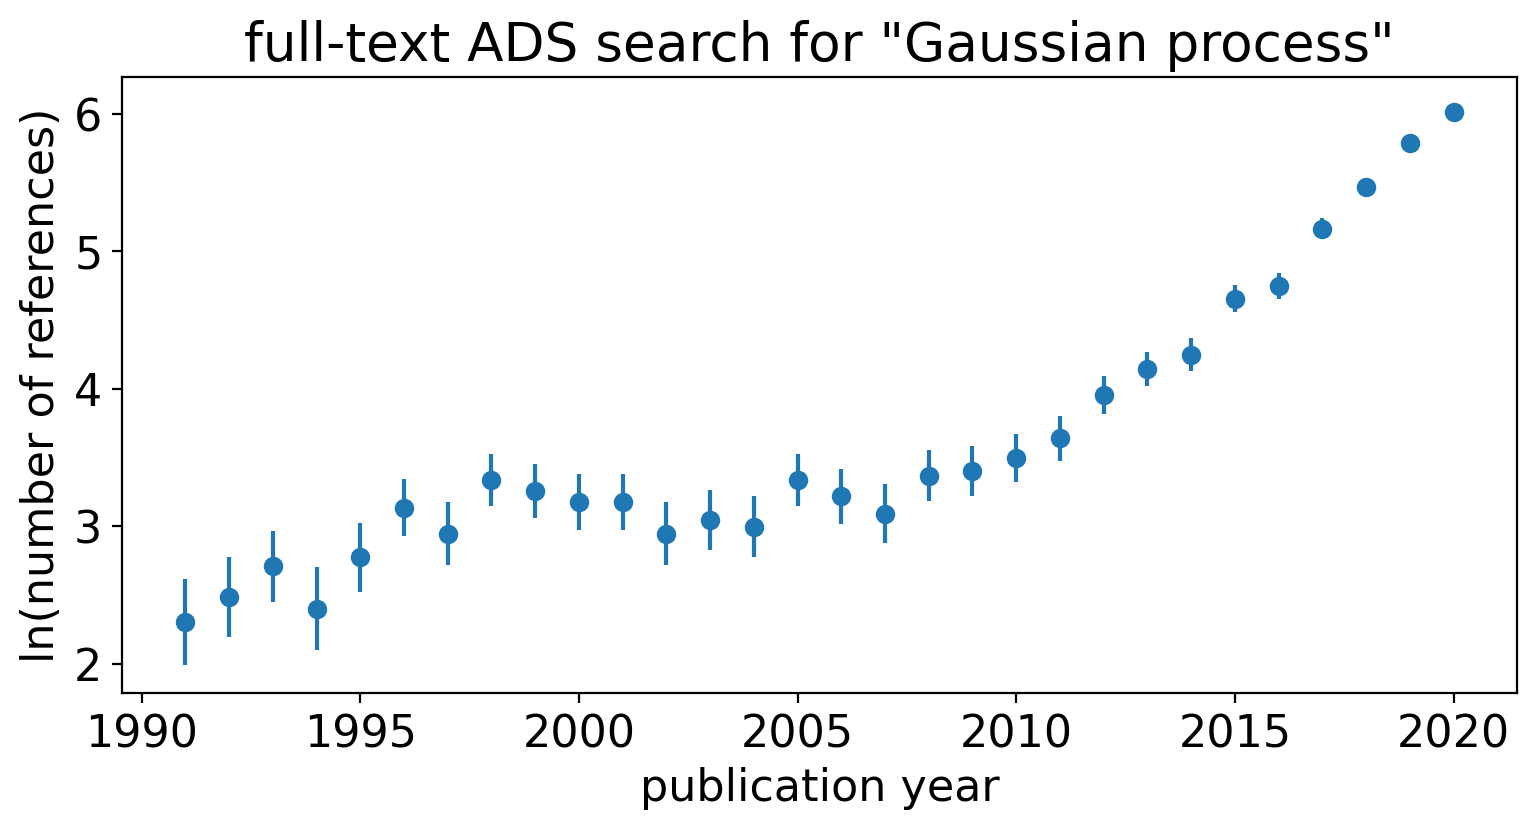

In [5]:
mask = (data["Year"] > 1990) & (data["Year"] <= 2020) & (data["Ref Count"] > 0)

year = data[mask]["Year"].astype(float)
count = data[mask]["Ref Count"].astype(float)
log_count = np.log(count)
count_sd = np.sqrt(count)
log_count_sd = count_sd / count

plt.errorbar(year, log_count, yerr=log_count_sd, fmt="o")
plt.xlabel("publication year")
plt.ylabel("ln(number of references)")
plt.title('full-text ADS search for "Gaussian process"')

In [6]:
def model(year, log_count, diag=None, year_pred=None):
    
    log_amp = numpyro.sample("log_amp", dist.Normal(0.0, 2.0))
    log_scale = numpyro.sample("log_scale", dist.Normal(0.0, 2.0))
    
    mu = numpyro.sample("mu", dist.Normal(4.0, 1.0))

    kernel = jnp.exp(log_amp) * kernels.ExpSquared(jnp.exp(log_scale))
    gp = GaussianProcess(kernel, year, diag=diag, mean=mu)
    
    numpyro.sample("log_count", gp.numpyro_dist(), obs=log_count)
    
    if year_pred is not None:
        gp_pred = gp.condition(log_count, year_pred).gp
        numpyro.sample("log_count_pred", gp_pred.numpyro_dist())

In [7]:
sampler = NUTS(model)
mcmc = MCMC(sampler, num_warmup=1000, num_samples=1000, num_chains=2)

/var/folders/zr/3f9t9zzs1tq27438cp0fqn19z0ds79/T/ipykernel_24072/3103390951.py:2: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(sampler, num_warmup=1000, num_samples=1000, num_chains=2)


In [8]:
rng = random.PRNGKey(0)
rng, key = random.split(rng)

diag = log_count_sd**2
mcmc.run(key, year, log_count, diag=diag)

sample: 100%|█████████████████████████████████████████| 2000/2000 [00:02<00:00, 780.59it/s, 15 steps of size 4.06e-01. acc. prob=0.94]


In [9]:
mcmc.print_summary()


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
    log_amp      1.44      0.84      1.37      0.21      2.92   1032.75      1.00
  log_scale      2.37      0.26      2.40      1.95      2.78    970.83      1.00
         mu      4.02      0.81      3.99      2.73      5.32   1021.74      1.00

Number of divergences: 0


In [10]:
year_pred = jnp.linspace(year.min(), year.max(), 201)
predictive = Predictive(model, mcmc.get_samples())

rng, key = random.split(rng)
pred = predictive(key, year, log_count, diag=diag, year_pred=year_pred)

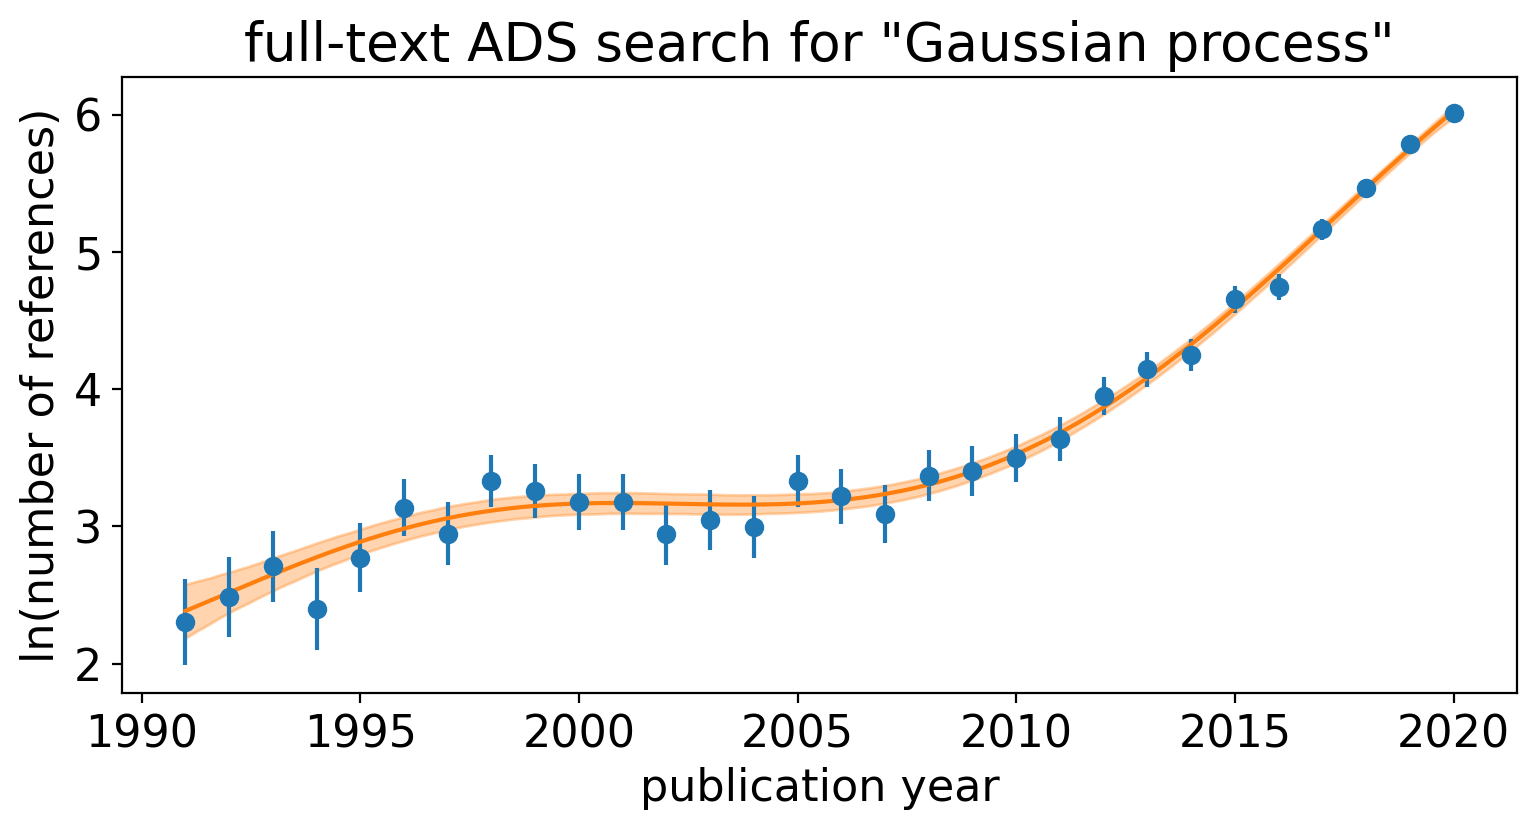

In [11]:
log_count_pred = pred["log_count_pred"].mean(axis=0)
lower, upper = np.quantile(pred["log_count_pred"], [.16, .84], axis=0)

plt.errorbar(year, log_count, yerr=log_count_sd, fmt="o")
plt.xlabel("publication year")
plt.ylabel("ln(number of references)")
plt.title('full-text ADS search for "Gaussian process"')

plt.plot(year_pred, log_count_pred, color="C1")
plt.fill_between(year_pred, lower, upper, color="C1", alpha=0.33)

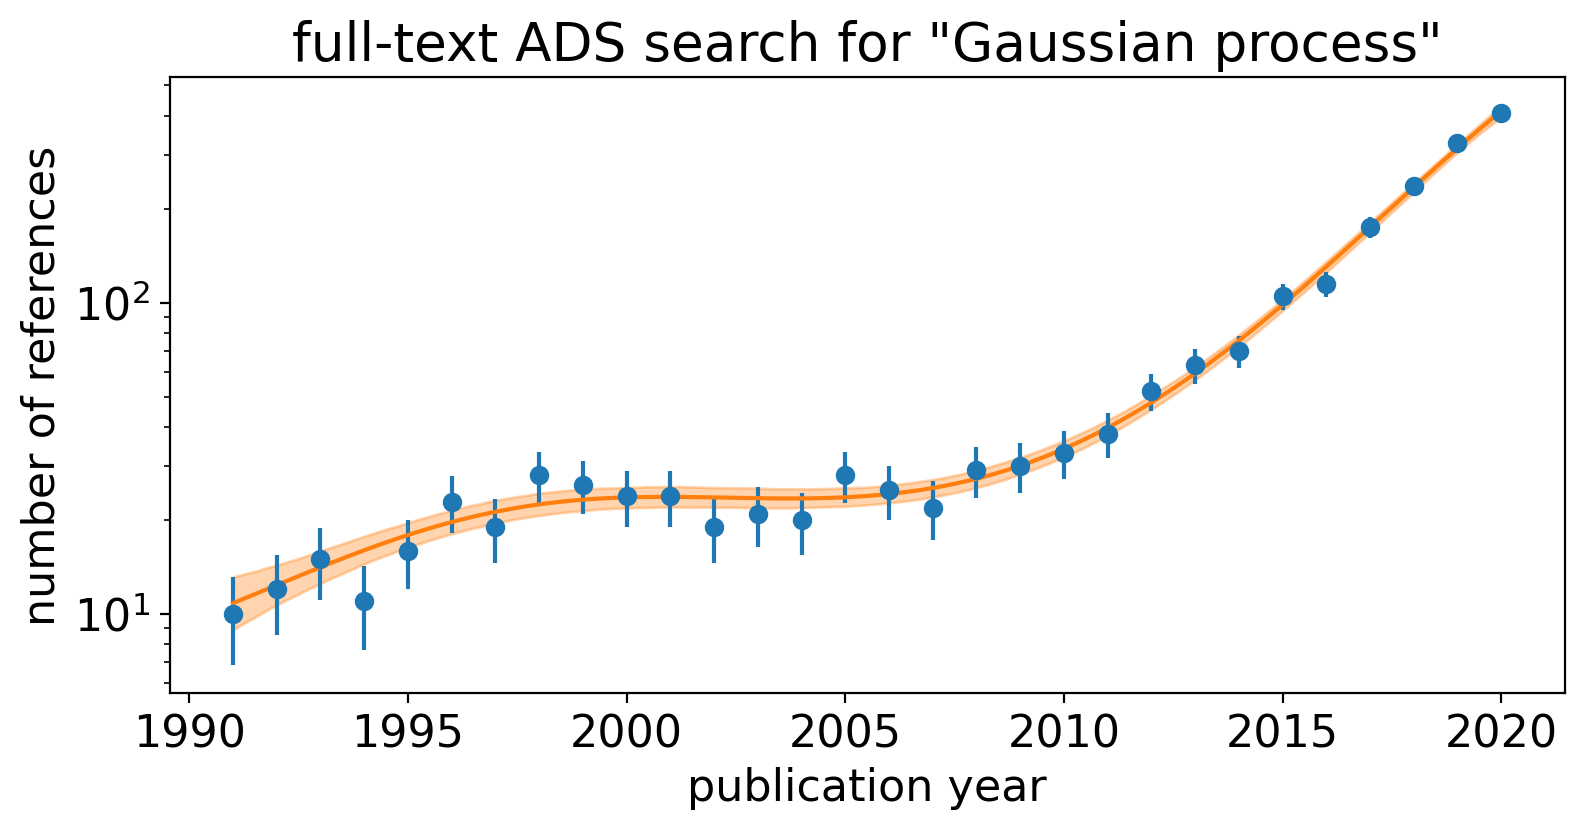

In [12]:
plt.errorbar(year, count, yerr=count_sd, fmt="o")
plt.yscale("log")
plt.xlabel("publication year")
plt.ylabel("number of references")
plt.title('full-text ADS search for "Gaussian process"')

plt.plot(year_pred, np.exp(log_count_pred), color="C1")
plt.fill_between(year_pred, np.exp(lower), np.exp(upper), color="C1", alpha=0.33)

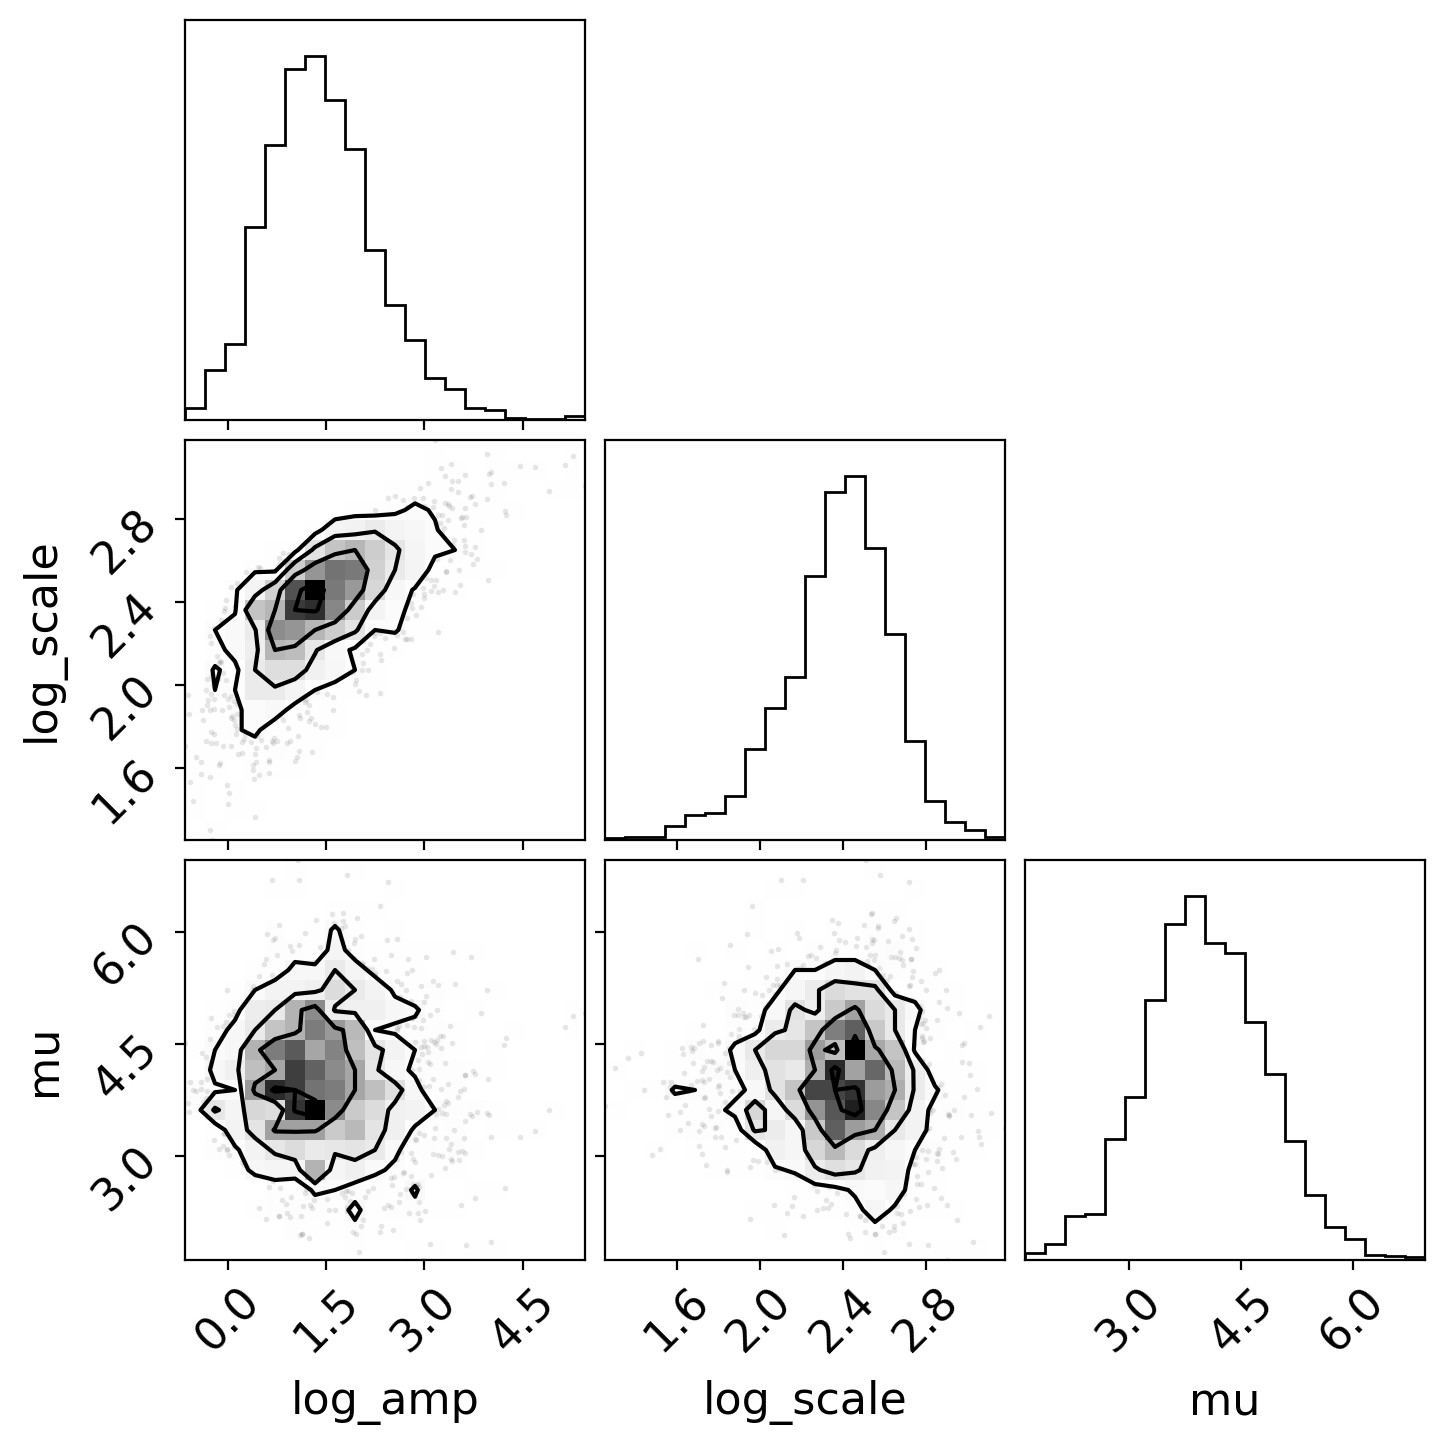

In [13]:
samples = mcmc.get_samples(group_by_chain=True)
fig = corner(samples)

In [14]:
# year_test = np.atleast_1d(2021)
year_test = np.array([2019, 2021])
rng, key = random.split(rng)
test = predictive(key, year, log_count, diag=diag, year_pred=year_test)

In [15]:
df = data.to_pandas()

count_test = np.exp(test["log_count_pred"])
count_true = df.loc[df["Year"].isin(year_test), "Ref Count"].to_numpy()
count_true_sd = np.sqrt(count_true)

Text(0.5, 0, 'ref count')

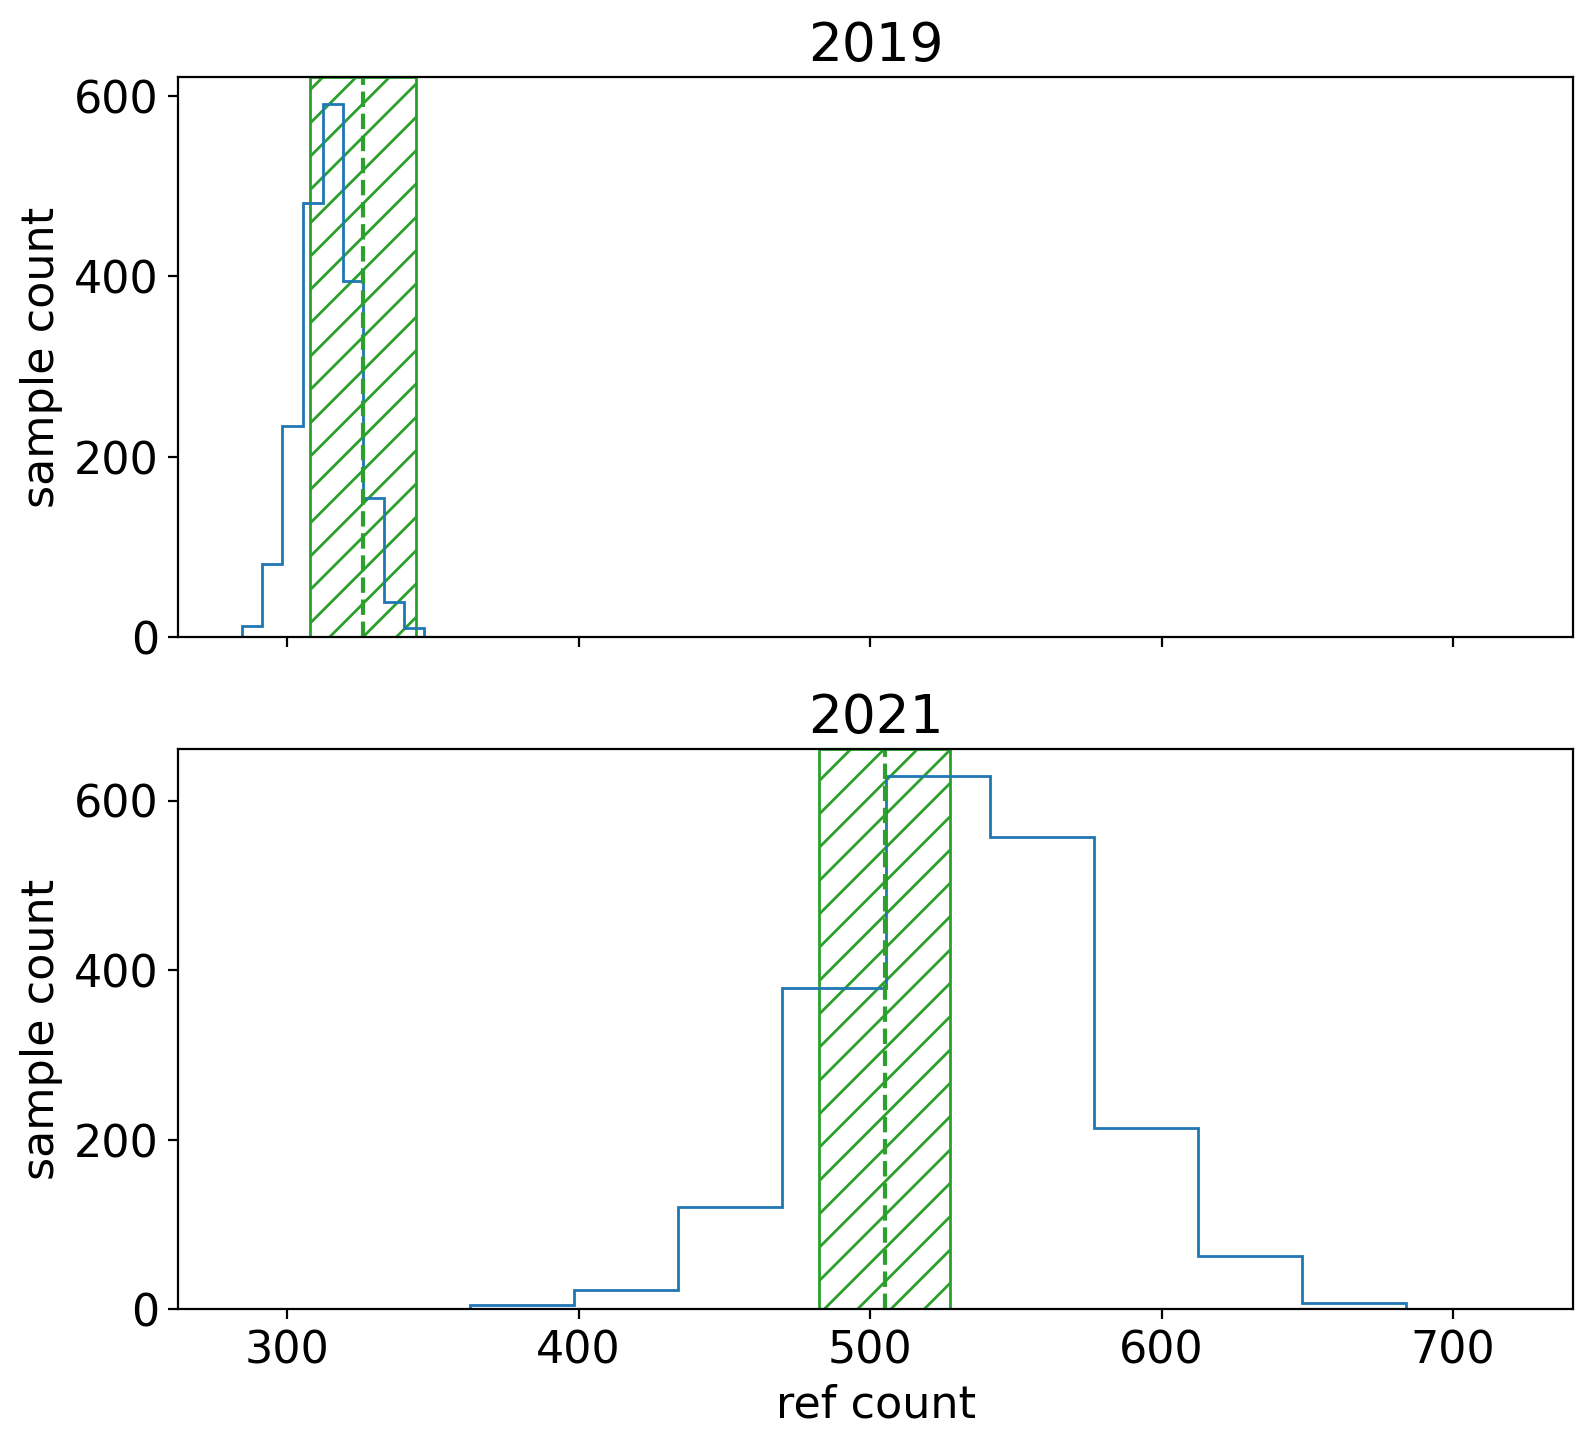

In [16]:
num_years = len(year_test)

fig, axes = plt.subplots(nrows=num_years, 
                         figsize=(9, 4*num_years),
                         sharex=True)
for i in range(num_years):
    ax = axes[i]
    ax.set_title(year_test[i])
    ax.hist(count_test[:, i], histtype="step", color="C0")
    ax.axvline(count_true[i], color="C2", linestyle="--")
    ax.axvspan(
            count_true[i]-count_true_sd[i],
            count_true[i]+count_true_sd[i], 
            edgecolor="C2",
            facecolor="none", 
            hatch="//",
        )
    ax.set_ylabel("sample count")
ax.set_xlabel("ref count")